# Audio2Blendshape test notebook

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scripts.Dataset import a2bsDataset
from scripts.SimpleNet import FaceGenerator, RMSLELoss

## Initialize train-eval-test split
Set *build_cache=True* to buid cache if it doesn't already exist.

In [2]:
train_data = a2bsDataset(loader_type='train', mount_dir = '.', data_dir = 'datasets', build_cache=True, map_gb=2, is_win=True, file_cut=15)
train_loader = torch.utils.data.DataLoader(
            train_data, 
            batch_size=16,  
            shuffle=True,  
            num_workers=0,
            drop_last=True,
        )

.\datasets\1\1_wayne_0_65_72.wav
.\datasets\1\1_wayne_0_81_86.wav
.\datasets\1\1_wayne_0_103_110.wav
.\datasets\1\1_wayne_0_95_102.wav
.\datasets\1\1_wayne_0_33_40.wav
.\datasets\1\1_wayne_0_57_64.wav
.\datasets\1\1_wayne_0_17_24.wav
.\datasets\1\1_wayne_0_111_118.wav
.\datasets\1\1_wayne_0_9_16.wav
.\datasets\1\1_wayne_0_25_32.wav
.\datasets\1\1_wayne_0_49_56.wav
.\datasets\1\1_wayne_0_73_80.wav
.\datasets\1\1_wayne_0_87_94.wav
.\datasets\1\1_wayne_0_1_8.wav
.\datasets\1\1_wayne_0_41_48.wav


In [3]:
len(train_data)

7689

In [4]:
eval_data = a2bsDataset(loader_type='eval', mount_dir = '.', data_dir = 'datasets', build_cache=False,map_gb=1, is_win=True)
eval_loader = torch.utils.data.DataLoader(
            eval_data, 
            batch_size=16,  
            shuffle=True,  
            num_workers=0,
            drop_last=True,
        )

In [5]:
len(eval_data)

1316

In [6]:
in_audio, facial, in_id = next(iter(train_loader))

In [7]:
print(in_audio.shape, facial.shape, in_id.shape)

torch.Size([16, 36266]) torch.Size([16, 34, 51]) torch.Size([16, 1])


In [8]:
net = FaceGenerator().cuda()
optimizer = torch.optim.Adam( net.parameters(), lr=1e-3, weight_decay=1e-5)
loss_function = RMSLELoss()
train_loss = []
eval_loss = []

In [11]:
num_epochs = 5
log_period = 100
eval_period = 400

for epoch in range(num_epochs):
    for it, (in_audio, facial, in_id) in enumerate(train_loader):
        net.train()
        in_audio = in_audio.cuda()
        facial = facial.cuda()
        pre_frames = 4
        in_pre_face = facial.new_zeros((facial.shape[0], facial.shape[1], facial.shape[2] + 1)).cuda()
        in_pre_face[:, 0:pre_frames, :-1] = facial[:, 0:pre_frames]
        in_pre_face[:, 0:pre_frames, -1] = 1 
        
        optimizer.zero_grad()
        out_face = net(in_pre_face,in_audio)
        loss = loss_function(facial, out_face)
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()
        
        #logging
        if it % log_period == 0:
            print(f'[{epoch}][{it}/{len(train_loader)}] loss: {loss.item()}')
        
        if it % eval_period == 0:
            net.eval()
            eval_loss_st = []
            for _, (in_audio, facial, in_id) in enumerate(eval_loader):
                in_audio = in_audio.cuda()
                facial = facial.cuda()
                pre_frames = 4
                in_pre_face = facial.new_zeros((facial.shape[0], facial.shape[1], facial.shape[2] + 1)).cuda()
                in_pre_face[:, 0:pre_frames, :-1] = facial[:, 0:pre_frames]
                in_pre_face[:, 0:pre_frames, -1] = 1 

                out_face = net(in_pre_face,in_audio)
                loss = loss_function(facial, out_face)
                eval_loss_st.append(loss.item())
            
            eval_loss.append(np.average(eval_loss_st))
            print(f'[{epoch}][{it}/{len(train_loader)}] eval loss: {np.average(eval_loss_st)}')

[0][0/480] loss: 0.06552492082118988
[0][0/480] eval loss: 0.06777794859031351
[0][100/480] loss: 0.058236729353666306
[0][200/480] loss: 0.06363499164581299
[0][300/480] loss: 0.06215270981192589
[0][400/480] loss: 0.05690266191959381
[0][400/480] eval loss: 0.0642159429446953
[1][0/480] loss: 0.06540224701166153
[1][0/480] eval loss: 0.06574139571407946
[1][100/480] loss: 0.058802828192710876
[1][200/480] loss: 0.056573644280433655
[1][300/480] loss: 0.054899949580430984
[1][400/480] loss: 0.058303482830524445
[1][400/480] eval loss: 0.06408307660461926
[2][0/480] loss: 0.061603475362062454
[2][0/480] eval loss: 0.07957556571175413
[2][100/480] loss: 0.06393890827894211
[2][200/480] loss: 0.054632801562547684
[2][300/480] loss: 0.06491231918334961
[2][400/480] loss: 0.06190839409828186
[2][400/480] eval loss: 0.06297135443949117
[3][0/480] loss: 0.054869480431079865
[3][0/480] eval loss: 0.06133359684268149
[3][100/480] loss: 0.060666777193546295
[3][200/480] loss: 0.0493017584085464

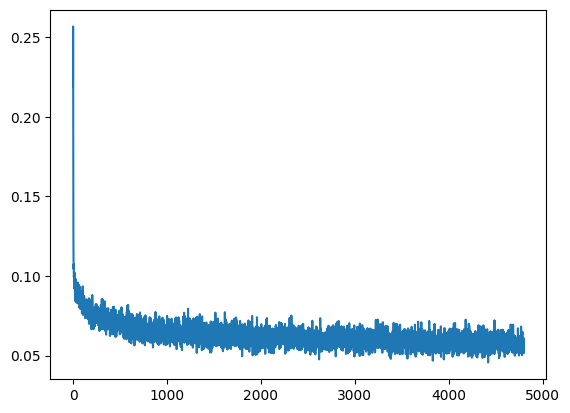

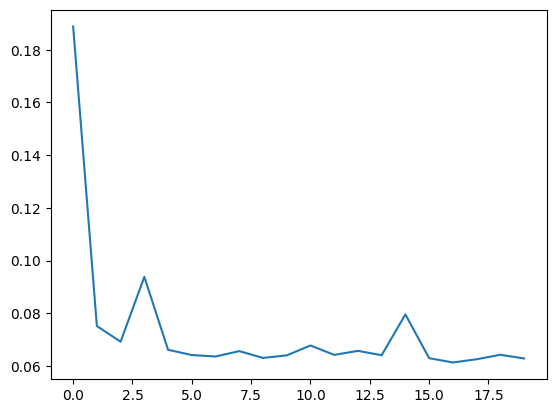

In [12]:
plt.plot(train_loss)
plt.show()
plt.plot(eval_loss)
plt.show()

In [22]:
net.load_state_dict(torch.load('ckpt_model/simplenet1.pth'))

<All keys matched successfully>

In [23]:
net.eval()
in_audio, facial, in_id = next(iter(eval_loader))
in_audio = in_audio.cuda()
facial = facial.cuda()
pre_frames = 4
in_pre_face = facial.new_zeros((facial.shape[0], facial.shape[1], facial.shape[2] + 1)).cuda()
in_pre_face[:, 0:pre_frames, :-1] = facial[:, 0:pre_frames]
in_pre_face[:, 0:pre_frames, -1] = 1 
out_face = net(in_pre_face, in_audio)

In [24]:
out_face.shape, facial.shape

(torch.Size([16, 34, 51]), torch.Size([16, 34, 51]))

In [25]:
out_face[0,:,7]

tensor([0.1493, 0.1571, 0.1694, 0.1748, 0.1854, 0.1972, 0.2174, 0.2400, 0.2486,
        0.2089, 0.1599, 0.1585, 0.2019, 0.2410, 0.2583, 0.2642, 0.2511, 0.1794,
        0.1239, 0.1295, 0.1869, 0.2404, 0.2813, 0.2985, 0.3080, 0.3009, 0.2949,
        0.2887, 0.2912, 0.2923, 0.2903, 0.2908, 0.2930, 0.2910],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [26]:
facial[0,:,7]

tensor([0.1280, 0.1553, 0.1621, 0.1729, 0.2174, 0.2680, 0.3000, 0.3049, 0.2813,
        0.1548, 0.1302, 0.2010, 0.2466, 0.3037, 0.3263, 0.3356, 0.3306, 0.1797,
        0.1378, 0.1832, 0.2672, 0.3036, 0.2647, 0.2499, 0.2555, 0.2548, 0.1862,
        0.1620, 0.1989, 0.2137, 0.2489, 0.2604, 0.2631, 0.2611],
       device='cuda:0')

In [21]:
torch.save(net.state_dict(), 'ckpt_model/simplenet1.pth')

## Test set

In [1]:
import scipy
import math
import numpy as np
import torch
from tqdm import tqdm
from scripts.SimpleNet import FaceGenerator

In [2]:
test_audio_file = 'test_audio/out5.wav'
sr, test_audio_raw = scipy.io.wavfile.read(test_audio_file) # np array
test_audio = test_audio_raw[::sr//16000] # convert to 16khz
print('Original sample rate:', sr)

Original sample rate: 22050


In [3]:
len(test_audio)

225328

In [58]:
# need to separate into 32 frames, pass in 4 zeroed starting frames, set stride, do last frame fixes
facial_length = 34
facial_fps = 15
audio_fps = 16000
pre_frames = 4
stride = 4

In [20]:
net = FaceGenerator().cuda().eval()

In [59]:
audio_start = 0
audio_end = audio_start + audio_short_length
face_start = 0
audio_short_length = math.floor(facial_length / facial_fps * audio_fps)
face_cache = np.zeros((1,(len(test_audio) * facial_fps) // audio_fps ,51))
with tqdm(total=(face_cache.shape[1]-facial_length)//stride+1) as pbar:
    while audio_end < len(test_audio):
        in_audio = torch.from_numpy(test_audio[audio_start:audio_end]).view(1,-1).float().cuda()
        pre_face = torch.from_numpy(face_cache[:,face_start:face_start+facial_length,:]).float()
        in_pre_face = pre_face.new_zeros((pre_face.shape[0], pre_face.shape[1], pre_face.shape[2] + 1)).cuda()
        in_pre_face[:, face_start:face_start+pre_frames, :-1] = pre_face[:, face_start:face_start+pre_frames]
        in_pre_face[:, face_start:face_start+pre_frames, -1] = 1 
        #print(in_pre_face.shape, in_audio.shape)
        with torch.no_grad():
            out_face = net(in_pre_face, in_audio)

        face_cache[:,face_start:face_start+facial_length,:] = out_face.cpu().numpy()
    
        face_start += stride
        audio_start = (face_start*audio_fps)//facial_fps
        audio_end = audio_start + audio_short_length
        pbar.update(1)

100%|████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 61.04it/s]


In [61]:
print(face_cache[:,-2,:])

[[-0.1046859   0.05207654  0.03157391  0.09902284  0.03018985  0.06223929
   0.12616611 -0.00736351  0.046001   -0.13210353 -0.08254468 -0.19113624
  -0.024583    0.14247781 -0.07941018 -0.26639786 -0.04473998 -0.0337305
  -0.04408435  0.02667639 -0.05597728  0.08636665  0.00871559  0.15929121
   0.0009105  -0.02556583  0.0659435  -0.03973598 -0.03766516 -0.02535535
  -0.15572986 -0.17322475 -0.03394254 -0.01126326 -0.0660804   0.0213711
  -0.07410437  0.03205837 -0.18089542 -0.13476083  0.10968086 -0.12431906
  -0.13928674 -0.0816057   0.0511675  -0.05160924  0.03679578  0.20694439
   0.10554428  0.06083784  0.10627229]]
